# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [15]:
import requests
import time
import json
import pandas as pd

In [198]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [17]:
url = 'http://www.reddit.com'

In [18]:
headers = {'User-agent': 'Bleep blorp bot 0.1'}

In [19]:
res = requests.get(url, headers=headers)

In [20]:
res.status_code

200

# Creating praw and testing features I will want to use

In [21]:
# imported praw for cleaning purposes
# created instance for reddit
# pulling attributes

import praw
reddit = praw.Reddit(client_id='PzTTVerHRivt8g', 
                     client_secret="1LnaL_AwwjQPp3SlATzAHBN1NfE",
                     password='Kingvzw100$', 
                     user_agent='Projet 3sam',
                     username='HPatterson4')

# pulling attributes
subreddit = reddit.subreddit('python')
hot_python = subreddit.hot(limit = 10)
for submission in hot_python:
    print(dir(submission))

['STR_FIELD', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_chunk', '_comments_by_id', '_fetch', '_fetched', '_flair', '_info_params', '_info_path', '_mod', '_reddit', '_reset_attributes', '_safely_add_arguments', '_url_parts', '_vote', 'approved_at_utc', 'approved_by', 'archived', 'author', 'author_flair_background_color', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_template_id', 'author_flair_text', 'author_flair_text_color', 'author_flair_type', 'author_id', 'banned_at_utc', 'banned_by', 'can_gild', 'can_mod_post', 'category', 'clear_vote', 'clicked', 'comment_limit', 'comment_sort', 'comments', 'content_categories', 'contest_mode', 'created', 'created_

In [22]:
subreddit = reddit.subreddit('python')
hot_python = subreddit.hot(limit = 5)
for submission in hot_python:
    print(submission.url)

https://www.reddit.com/r/Python/comments/8bx6md/rpython_official_job_board/
https://www.reddit.com/r/Python/comments/8xpgyu/whats_everyone_working_on_this_week/
https://www.reddit.com/r/Python/comments/8z0pxo/suggestion_remove_codingbat_from_side_bar/
https://github.com/alexmojaki/sorcery
https://youtu.be/_w3a1ledmVE


In [23]:
subreddit = reddit.subreddit('python')
hot_python = subreddit.hot(limit = 5)
for submission in hot_python:
    print(submission.ups)

116
22
306
20
10


In [24]:
subreddit = reddit.subreddit('python')
hot_python = subreddit.hot(limit = 5)
for submission in hot_python:
    print(submission.title)

r/Python Official Job Board
What's everyone working on this week?
Suggestion: Remove CodingBat from side bar
sorcery: Dark magic delights in Python
Understanding Python Bytecode | PyCon 2018


In [31]:
# Set a variable equal to the target subreddit
r_all = reddit.subreddit('all')


# Grab submissions from the subreddit
subs = []
for sub in r_all.hot(limit=1000):
    sub_dict = {}
    sub_dict['submissions'] = sub
    subs.append(sub_dict)
subscrape = pd.DataFrame(subs)
subscrape.shape, subscrape.head()

# Save submission pull to csv
subscrape.to_csv("sub_redd.csv")

# Grab features from the submission IDs
sublist = []
for c in subscrape['submissions']:
    subdict = {}
    subdict['title'] = c.title
    subdict['comments'] = c.num_comments
    subdict['subreddit'] = c.subreddit
    subdict['created'] = c.created
    subdict['ups'] = c.ups
    subdict['URL'] = c.url
    sublist.append(subdict)
time.sleep(1)

In [32]:
# create dataframe
reddit_final = pd.DataFrame(sublist)

In [33]:
reddit_final

,URL,comments,created,subreddit,title,ups
0,http://www.thesmokinggun.com//documents/celebr...,1387,1.531709e+09,todayilearned,TIL Madonna leaked a fake version of her album...,29588
1,https://i.redd.it/5rbdwrt4n5a11.jpg,281,1.531708e+09,aww,"I haven’t met my new neighbor yet, but her dog...",36194
2,https://i.redd.it/jvkk2xwhf5a11.jpg,652,1.531705e+09,pcmasterrace,this is kinda true,23399
3,https://i.redd.it/j0642xwgc5a11.jpg,272,1.531704e+09,BikiniBottomTwitter,Dennis has a son,21195
4,https://twitter.com/FIFAWorldCup/status/101854...,1179,1.531704e+09,soccer,Luka Modrić wins the 2018 World Cup Golden Ball,11031
5,https://i.redd.it/7x4nu2lg85a11.jpg,442,1.531704e+09,Art,"Beautiful Bismuth, Digital, 2000x2500px",24313
6,https://io9.gizmodo.com/bogus-production-probl...,1155,1.531702e+09,movies,Keanu Reeves' 'Bill & Ted 3' Facing Production...,21584
7,https://i.redd.it/xxd907ut95a11.jpg,2263,1.531704e+09,pics,French President celebrates during the final !,81717
8,https://i.redd.it/8jhk1xoo95a11.jpg,244,1.531704e+09,natureismetal,This sick washed up gar skeleton I found.,14233
9,https://i.redd.it/h25aj9lpa5a11.jpg,841,1.531704e+09,photoshopbattles,PsBattle: French President celebrating,45013


## (Optional) Collect more information
​
While we only require you to collect four features, there may be other info that you can find on the results page that might be useful. Feel free to write more functions so that you have more interesting and useful data.

In [ ]:
## played around in previous code with the different features 
## keep the ones I wanted to use

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [34]:
reddit_final.to_csv('scrapped to csv')

# Cleaning

In [157]:
comments.head()

,URL,comments,created,subreddit,title,ups
0,http://www.thesmokinggun.com//documents/celebr...,1387,1.531709e+09,todayilearned,TIL Madonna leaked a fake version of her album...,29588
1,https://i.redd.it/5rbdwrt4n5a11.jpg,281,1.531708e+09,aww,"I haven’t met my new neighbor yet, but her dog...",36194
2,https://i.redd.it/jvkk2xwhf5a11.jpg,652,1.531705e+09,pcmasterrace,this is kinda true,23399
3,https://i.redd.it/j0642xwgc5a11.jpg,272,1.531704e+09,BikiniBottomTwitter,Dennis has a son,21195
4,https://twitter.com/FIFAWorldCup/status/101854...,1179,1.531704e+09,soccer,Luka Modrić wins the 2018 World Cup Golden Ball,11031


In [153]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
URL          1000 non-null object
comments     1000 non-null int64
created      1000 non-null float64
subreddit    1000 non-null object
title        1000 non-null object
ups          1000 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


In [154]:
comments.columns

Index(['URL', 'comments', 'created', 'subreddit', 'title', 'ups'], dtype='object')

In [156]:
comments.shape

(1000, 6)

In [160]:
comments.isnull().sum()

URL          0
comments     0
created      0
subreddit    0
title        0
ups          0
dtype: int64

## Predicting comments using Random Forests + Another Classifier

#### Load in the the data of scraped results

In [35]:
comments = pd.read_csv('/Users/harrypatterson/dsi/project-3/scrapped to csv')
comments.head()

,Unnamed: 0,URL,comments,created,subreddit,title,ups
0,0,http://www.thesmokinggun.com//documents/celebr...,1387,1.531709e+09,todayilearned,TIL Madonna leaked a fake version of her album...,29588
1,1,https://i.redd.it/5rbdwrt4n5a11.jpg,281,1.531708e+09,aww,"I haven’t met my new neighbor yet, but her dog...",36194
2,2,https://i.redd.it/jvkk2xwhf5a11.jpg,652,1.531705e+09,pcmasterrace,this is kinda true,23399
3,3,https://i.redd.it/j0642xwgc5a11.jpg,272,1.531704e+09,BikiniBottomTwitter,Dennis has a son,21195
4,4,https://twitter.com/FIFAWorldCup/status/101854...,1179,1.531704e+09,soccer,Luka Modrić wins the 2018 World Cup Golden Ball,11031


In [36]:
comments.drop('Unnamed: 0', axis = 1, inplace=True) 
comments.head()

,URL,comments,created,subreddit,title,ups
0,http://www.thesmokinggun.com//documents/celebr...,1387,1.531709e+09,todayilearned,TIL Madonna leaked a fake version of her album...,29588
1,https://i.redd.it/5rbdwrt4n5a11.jpg,281,1.531708e+09,aww,"I haven’t met my new neighbor yet, but her dog...",36194
2,https://i.redd.it/jvkk2xwhf5a11.jpg,652,1.531705e+09,pcmasterrace,this is kinda true,23399
3,https://i.redd.it/j0642xwgc5a11.jpg,272,1.531704e+09,BikiniBottomTwitter,Dennis has a son,21195
4,https://twitter.com/FIFAWorldCup/status/101854...,1179,1.531704e+09,soccer,Luka Modrić wins the 2018 World Cup Golden Ball,11031


#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

In [ ]:
Avgcomments = comments['comments'].mean()
Avgcomments

In [162]:
comments["Binary"] = np.where(comments["comments"]>Avgcomments, 1, 0)

In [163]:
comments.head()

,URL,comments,created,subreddit,title,ups,Binary
0,http://www.thesmokinggun.com//documents/celebr...,1387,1.531709e+09,todayilearned,TIL Madonna leaked a fake version of her album...,29588,1
1,https://i.redd.it/5rbdwrt4n5a11.jpg,281,1.531708e+09,aww,"I haven’t met my new neighbor yet, but her dog...",36194,1
2,https://i.redd.it/jvkk2xwhf5a11.jpg,652,1.531705e+09,pcmasterrace,this is kinda true,23399,1
3,https://i.redd.it/j0642xwgc5a11.jpg,272,1.531704e+09,BikiniBottomTwitter,Dennis has a son,21195,1
4,https://twitter.com/FIFAWorldCup/status/101854...,1179,1.531704e+09,soccer,Luka Modrić wins the 2018 World Cup Golden Ball,11031,1


In [167]:
comments['Binary'].value_counts(normalize=True)


0    0.801
1    0.199
Name: Binary, dtype: float64

In [169]:
y = comments['Binary']
X = Avgcomments

In [170]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Binary, dtype: int64

In [171]:
X

197.026

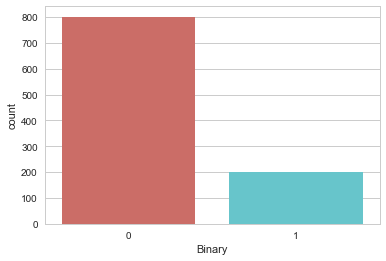

AttributeError: module 'matplotlib.pyplot' has no attribute 'savefit'

In [172]:
sns.countplot(y, palette='hls')
plt.show()
plt.savefit('count_plot')

In [173]:
Binary.shape

(1000, 1)

In [174]:
commentsTorF = []
for i in comments:
    subT = {}
    subT['title'] = c.title
    subT['comments'] = c.num_comments
    subT['subreddit'] = c.subreddit
    commentsTorF.append(subT)
pd.DataFrame(commentsTorF)

,comments,subreddit,title
0,290,gaming,Greatest gaming moment?
1,290,gaming,Greatest gaming moment?
2,290,gaming,Greatest gaming moment?
3,290,gaming,Greatest gaming moment?
4,290,gaming,Greatest gaming moment?
5,290,gaming,Greatest gaming moment?
6,290,gaming,Greatest gaming moment?


In [175]:
pd.DataFrame(commentsTorF)

,comments,subreddit,title
0,290,gaming,Greatest gaming moment?
1,290,gaming,Greatest gaming moment?
2,290,gaming,Greatest gaming moment?
3,290,gaming,Greatest gaming moment?
4,290,gaming,Greatest gaming moment?
5,290,gaming,Greatest gaming moment?
6,290,gaming,Greatest gaming moment?


#### Thought experiment: What is the baseline accuracy for this model?

In [78]:
## YOUR CODE HERE
Avgcomments

197.026

# create dummies

In [177]:
comments_dummies = pd.get_dummies(comments, columns=['Binary', 'title'])
comments_dummies.head()

,URL,comments,created,subreddit,ups,Binary_0,Binary_1,"title_""Did you miss me?!""","title_""Ghost in the Fog"" by daniel_b_demented from the official DBD Fan Contest.","title_""I think the European Union is a foe,"" Trump says ahead of Putin meeting in Helsinki",...,title_“Cheese” burger,"title_“I’m sorry little one...but as they say, I did nothing wrong.”","title_“Koloktos”, boss of “The Ancient Cistern” from “Zelda, Skyward Sword” is a mechanical entity that has been possessed by dark energy, and this is shown by a purple substance inside it. I wonder if this was a precursor to the possessed guardians and divine beasts from “Breath of the Wild”.","title_“Make sure you’re recording. I want to send it to Mom, she’s always hated I bought this”",title_“That’s fuckin hot!” -Dan,"title_“When West Virginia teachers went on strike, Bernie Sanders called immediately and asked the teachers what he could do to help.” -Randi Weingarten",title_👅,title_🔥 Blue Mycean Mushroom,title_🔥 Siberian Tiger covered in snow,title_🛁👰🏼😢
0,http://www.thesmokinggun.com//documents/celebr...,1387,1.531709e+09,todayilearned,29588,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,https://i.redd.it/5rbdwrt4n5a11.jpg,281,1.531708e+09,aww,36194,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,https://i.redd.it/jvkk2xwhf5a11.jpg,652,1.531705e+09,pcmasterrace,23399,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,https://i.redd.it/j0642xwgc5a11.jpg,272,1.531704e+09,BikiniBottomTwitter,21195,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,https://twitter.com/FIFAWorldCup/status/101854...,1179,1.531704e+09,soccer,11031,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Log with dummies 

In [203]:
features = ['URL','created','subreddit','ups']

In [204]:
X = comments[features]
y = comments['Binary']

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

In [ ]:
print('Logreg intercept:', log_reg.intercept_)
print('Logreg coef(s):', log_reg.coef_)

# Logistic Regression regular

In [178]:
comments.head()

,URL,comments,created,subreddit,title,ups,Binary
0,http://www.thesmokinggun.com//documents/celebr...,1387,1.531709e+09,todayilearned,TIL Madonna leaked a fake version of her album...,29588,1
1,https://i.redd.it/5rbdwrt4n5a11.jpg,281,1.531708e+09,aww,"I haven’t met my new neighbor yet, but her dog...",36194,1
2,https://i.redd.it/jvkk2xwhf5a11.jpg,652,1.531705e+09,pcmasterrace,this is kinda true,23399,1
3,https://i.redd.it/j0642xwgc5a11.jpg,272,1.531704e+09,BikiniBottomTwitter,Dennis has a son,21195,1
4,https://twitter.com/FIFAWorldCup/status/101854...,1179,1.531704e+09,soccer,Luka Modrić wins the 2018 World Cup Golden Ball,11031,1


In [179]:
X = comments['title'].values
y = comments['Binary']

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [181]:
tvec = TfidfVectorizer(stop_words='english')
X_train_counts = tvec.fit_transform(X_train)
X_test_counts = tvec.transform(X_test)

In [182]:
log_reg = LogisticRegression()
log_reg.fit(X_train_counts, y_train)
log_reg.score(X_test_counts, y_test)

0.806060606060606

In [183]:
print('Logreg intercept:', log_reg.intercept_)
print('Logreg coef(s):', log_reg.coef_)

Logreg intercept: [-1.45087187]
Logreg coef(s): [[ 0.22802093 -0.08679222  0.35018509 ... -0.1244891  -0.10593011
  -0.07410856]]


In [184]:
comments.columns

Index(['URL', 'comments', 'created', 'subreddit', 'title', 'ups', 'Binary'], dtype='object')

In [185]:
features = ['URL','created','subreddit','ups']

In [211]:
X = comments[features]
y = comments['Binary']

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [213]:
log_reg = LogisticRegression()
log_reg.fit(X_train_counts, y_train)
log_reg.score(X_test_counts, y_test)

0.806060606060606

In [188]:
print('Logreg intercept:', log_reg.intercept_)
print('Logreg coef(s):', log_reg.coef_)

Logreg intercept: [-1.45087187]
Logreg coef(s): [[ 0.22802093 -0.08679222  0.35018509 ... -0.1244891  -0.10593011
  -0.07410856]]


In [189]:
coefs = pd.DataFrame(log_reg.coef_)

In [190]:
coefs

,0,1,2,3,4,5,6,7,8,9,...,2247,2248,2249,2250,2251,2252,2253,2254,2255,2256
0,0.228021,-0.086792,0.350185,0.239737,-0.112333,-0.075542,-0.064452,-0.093304,-0.06181,-0.040302,...,-0.257766,-0.095674,-0.082069,0.350004,-0.222731,-0.010865,0.255589,-0.124489,-0.10593,-0.074109


#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

In [191]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=41)

In [192]:
comments['title'].value_counts()/comments.shape[0]

hmmm                                                                                                                                                                                                                                                                                                0.003
me irl                                                                                                                                                                                                                                                                                              0.002
Highway Administration workers hate him                                                                                                                                                                                                                                                             0.002
The cat does not allow you to pet the kitty                                                               

In [193]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
URL          1000 non-null object
comments     1000 non-null int64
created      1000 non-null float64
subreddit    1000 non-null object
title        1000 non-null object
ups          1000 non-null int64
Binary       1000 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB


In [196]:
tree = DecisionTreeClassifier()
tree.fit(X_train_counts, y_train)
tree.score(X_test_counts, y_test)

0.7454545454545455

In [200]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [10],
    'max_features': [3, 4, 5],
    'max_depth': [None, 2, 3, 4]
}
gs = GridSearchCV(rf, param_grid=rf_params)
gs.fit(X_train_counts, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7985074626865671
{'max_depth': 2, 'max_features': 3, 'n_estimators': 10}


## Bagging Classifier

In [202]:
bag = BaggingClassifier()
bag_params = {
    'n_estimators': range(10, 21)
}
gs = GridSearchCV(bag, param_grid=bag_params)
gs.fit(X_train_counts, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7940298507462686
{'n_estimators': 19}


## Extra trees

In [201]:
et = ExtraTreesClassifier()
et.fit(X_train_counts, y_train)
et.score(X_test_counts, y_test)

0.8

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

In [77]:
## YOUR CODE HERE
## Did this above code 

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

In [ ]:
## YOUR CODE HERE
# did this above code 

#### Repeat the model-building process with a non-tree-based method.

In [ ]:
## YOUR CODE HERE
# did this above code 

#### Use Count Vectorizer from scikit-learn to create features from the thread titles. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [ ]:
## YOUR CODE HERE
# CountVectorizer was the same with or without the countvectorizer as seen above.

# Executive Summary
---
Put your executive summary in a Markdown cell below.

1) shows that obvisouly the comments that was above the average had way more ups
2) The data I gathered seem to not be enough to really make a summary. I would have to work more on this but as of now. I wanted to hand in the project to be able to finish labs and capsone

### BONUS
Refer to the README for the bonus parts

In [ ]:
## YOUR CODE HERE